In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import warnings
from sklearn.linear_model import LinearRegression
from sklearn import metrics
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\data\data\btcusdt_1h_train.csv")
# df = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\dataset\test\btcusdt_1h_test.csv")


In [3]:
def money_flow_index(data, period=14):
    # Calculate typical price
    typical_price = (data['high'] + data['low'] + data['close']) / 3

    # Calculate raw money flow
    raw_money_flow = typical_price * data['volume']

    # Get the direction of the money flow
    money_flow_direction = [1 if typical_price[i] > typical_price[i - 1] else (-1 if typical_price[i] < typical_price[i - 1] else 0) for i in range(1, len(typical_price))]

    # Pad the money flow direction with 0 for the first element
    money_flow_direction.insert(0, 0)

    # Calculate positive and negative money flow
    positive_money_flow = [0 if direction == -1 else raw_money_flow[i] for i, direction in enumerate(money_flow_direction)]
    negative_money_flow = [0 if direction == 1 else raw_money_flow[i] for i, direction in enumerate(money_flow_direction)]

    # Calculate 14-day sums of positive and negative money flow
    positive_money_flow_sum = pd.Series(positive_money_flow).rolling(window=period, min_periods=1).sum()
    negative_money_flow_sum = pd.Series(negative_money_flow).rolling(window=period, min_periods=1).sum()

    # Calculate money flow index
    money_flow_ratio = positive_money_flow_sum / negative_money_flow_sum
    money_flow_index = 100 - (100 / (1 + money_flow_ratio))

    return money_flow_index

# Example usage
# Assuming you have a DataFrame 'df' with columns 'High', 'Low', 'Close', and 'Volume'
# You can calculate the Money Flow Index like this:
df['MFI'] = money_flow_index(df)

# Note: Make sure your 

In [4]:
# df['delta_MFI'] = df['MFI'].diff()  
# df = df.dropna()

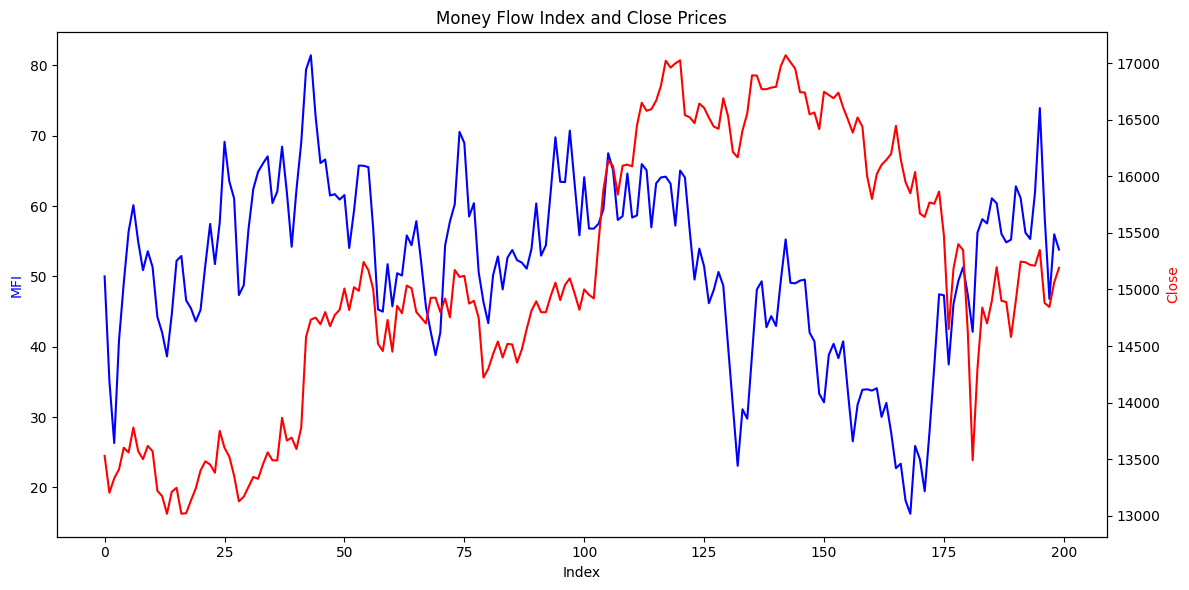

In [5]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax1.plot(df['MFI'][:200], color='blue')
ax2.plot(df['close'][:200], color='red')

ax1.set_title('Money Flow Index and Close Prices')
ax1.set_xlabel('Index')
ax1.set_ylabel('MFI', color='blue')
ax2.set_ylabel('Close', color='red')

plt.tight_layout()
plt.show()




In [6]:
def print_buckets(df, alphas, rets = ['ret_10', 'ret_30', 'ret_60', 'ret_300', 'tick_10'], aggfunc = ['mean', 'median', 'count'], buckets = 10):
# def print_buckets(df, alphas, rets = ['ret_10', 'ret_30', 'iv_10'], aggfunc = ['mean', 'median', 'count']):
# def print_buckets(df, alphas, rets = ['tick_10', 'tick_30', 'tick_60', 'tick_300'], aggfunc = ['mean', 'median', 'count']):
# def print_buckets(df, alphas, rets = ['ret_60', 'ret_300', 'iv_60'], aggfunc = ['mean', 'median', 'count']):
    for alpha in alphas:
        msg = df.pivot_table(index = pd.qcut(df[alpha],buckets,duplicates='drop'), values=rets, aggfunc=aggfunc)
        print(msg)

def print_corrs(df, alphas, rets = ['ret_10', 'ret_30', 'ret_60', 'ret_300']):
# def print_corrs(df, alphas, rets = ['ret_10', 'ret_30', 'iv_10']):
# def print_corrs(df, alphas, rets = ['tick_10', 'tick_30', 'tick_60', 'tick_300']):
# def print_corrs(df, alphas, rets = ['ret_60', 'ret_300', 'iv_60']):
    msg = "                                      "
    for ret in rets:
        msg += f"{ret:>8s}"
    print(msg)
    for alpha in alphas:
        msg = f"{alpha:30s} corr -> "
        for ret in rets:
            msg += f"{df[alpha].corr(df[ret])*100:7.2f} "
        print(msg)
    print()


In [7]:
df['change_5'] = df['close'].rolling(window=5).mean().pct_change() * 1e4

df['ret_5'] = df['close'].shift(-5)
df['ret_1'] = df['close'].shift(-1)
df['ret_10'] = df['close'].shift(-10)
df['ret_30'] = df['close'].shift(-30)

df['ret_5'] = (df['ret_5'] - df['close']) / df['close'] * 1e4
df['ret_1'] = (df['ret_1'] - df['close']) / df['close'] * 1e4
df['ret_10'] = (df['ret_10'] - df['close']) / df['close'] * 1e4
df['ret_30'] = (df['ret_30'] - df['close']) / df['close'] * 1e4

df.head(10)
df = df.dropna()
df = df.reset_index(drop=True)

In [8]:
print_corrs(df, ['MFI'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'])
print_buckets(df, ['MFI'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'])

                                         ret_5   ret_1  ret_10  ret_30
MFI                            corr ->    5.45    1.27    8.41    3.56 

                      mean                                     median  \
                     ret_1     ret_10     ret_30      ret_5     ret_1   
MFI                                                                     
(-0.001, 28.093] -2.266191 -47.484809 -45.558313 -23.738747  3.494286   
(28.093, 35.374] -3.004321 -30.772608  -4.767124 -13.956591  1.042960   
(35.374, 40.866]  2.243796   0.840013  19.667421   2.113160  1.827442   
(40.866, 45.586]  1.048245  12.292837  15.491438   3.984356  0.245421   
(45.586, 50.089] -1.987830  12.965101   9.053618   7.340964  0.924635   
(50.089, 54.534]  0.572775   1.037435  -5.318589  -0.977561  1.765009   
(54.534, 59.412]  1.781447   7.137769  -1.101619   4.849730  1.383008   
(59.412, 64.995] -1.057150   2.858275  16.895829   0.867660 -0.429034   
(64.995, 72.076]  1.993588  25.106207  31.029955  10.

In [9]:
df['flag'] = df['MFI'].apply(lambda x: 1 if x > 73 else (-1 if x < 38 else 0))

In [10]:
# df['k_flag'] = df['MFI'].apply(lambda x: 1 if x > 70 else (-1 if x < 30 else 0))
# df2 = df[['datetime', 'k_flag']]

In [11]:
# df2.head()

# df2.to_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\kushal.csv")

In [12]:
def generate_signals(df, flag_column):
    
    compare = 0
    counter = 0

    signals = pd.Series(0, index=df.index, name='signal')

    for i in range(len(df)):
        if df[flag_column].iloc[i] == 1 and compare == 0:
            # No open trade, encounter buy signal
            compare = 1
            signals.iloc[i] = 1

        elif df[flag_column].iloc[i] == -1 and compare == 0:
            # Current buy trade, encounter sell signal or no signal - update stop loss
            signals.iloc[i] = -1
            compare = -1

        elif compare != 0:
            if counter < 10:
                if df[flag_column].iloc[i] == 0:
                    counter += 1
                else:
                    if df[flag_column].iloc[i] == compare:
                        counter = counter // 2
                    else:
                        counter = 0
                        compare = 0
                        signals.iloc[i] = df[flag_column].iloc[i]

            else:
                signals.iloc[i] = -1 * compare
                counter = 0
                compare = 0

    df['signal'] = signals

# Example Usage:
# Assuming you have a DataFrame named 'df' with columns 'log' and 'flag'





generate_signals(df, 'flag')

In [13]:
# df.to_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\mfi.csv")

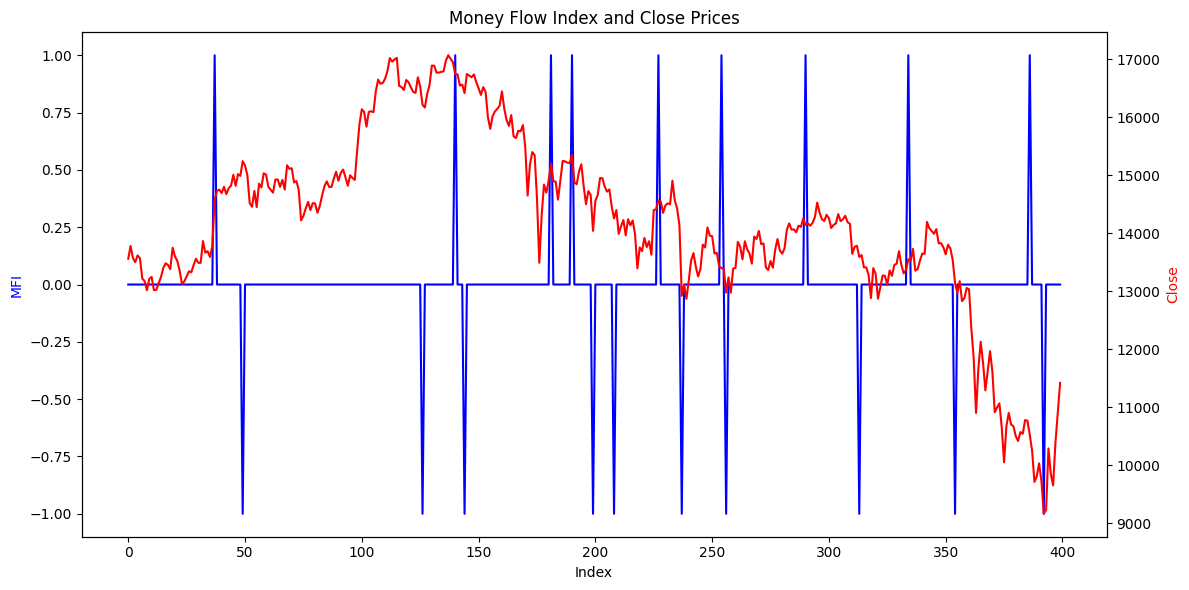

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax1.plot(df['signal'][:400], color='blue')
ax2.plot(df['close'][:400], color='red')

ax1.set_title('Money Flow Index and Close Prices')
ax1.set_xlabel('Index')
ax1.set_ylabel('MFI', color='blue')
ax2.set_ylabel('Close', color='red')

plt.tight_layout()
plt.show()

In [15]:
# compare = 0
# counter = 0

# for i in range(len(df)):
#     # if i % 10 == 0:
#     #     print(i)
#     if df['flag'].iloc[i] == 1 and compare == 0:
#         # No open trade, encounter buy signal
#         compare = 1
#         df['signal'].iloc[i] = 1
    
#     elif (df['flag'].iloc[i] == -1 and compare == 0):
#         # Current buy trade, encounter buy signal or no signal - update stop loss
#         df['signal'].iloc[i] = -1
#         compare = -1

#     elif compare != 0:
#         if counter < 10:
#             if df['flag'].iloc[i] == 0:
#                 counter += 1
#             else:
#                 if df['flag'].iloc[i] == compare:
#                     counter = counter//2

#                 else: 
#                     counter = 0
#                     compare = 0
#                     df['signal'].iloc[i] = df['flag'].iloc[i]
#         else:
#             df['signal'].iloc[i] = -1 * compare
#             counter = 0
#             compare = 0



In [16]:
df['signal'].value_counts()    

signal
 0    20857
 1      732
-1      732
Name: count, dtype: int64

In [17]:
df.to_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\mfi_check.csv")

In [18]:
df_kushal = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\obv_stoploss.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ayush\\Desktop\\IITB\\ZeltaLabPS\\BackTesting\\src\\logs\\obv_stoploss.csv'

In [ ]:
df_kushal['signal'].value_counts()  

signal
 0.0    21649
-1.0      228
 1.0      228
Name: count, dtype: int64

In [ ]:
# Convert 'datetime' column to datetime64[ns] type
df['datetime'] = pd.to_datetime(df['datetime'])
df_kushal['datetime'] = pd.to_datetime(df_kushal['datetime'])

# Merge DataFrames on 'datetime' column
df_merged = pd.merge(result_df, df_kushal, on='datetime', how='inner')

NameError: name 'result_df' is not defined

In [ ]:
df_merged['signal'] = np.nan
compare = 0
for i in range(len(df_merged)):

    # Opening a trade
    if df_merged['signal_x'].iloc[i] == 1 and df_merged['signal_y'].iloc[i] == 1 and compare == 0:
        df_merged['signal'].iloc[i] = 1
        compare = 1
    elif df_merged['signal_x'].iloc[i] == -1 and df_merged['signal_y'].iloc[i] == -1 and compare == 0:
        df_merged['signal'].iloc[i] = -1
        compare = -1
    elif df_merged['signal_x'].iloc[i] == 1 and df_merged['signal_y'].iloc[i] == 0 and compare == 0:
        df_merged['signal'].iloc[i] = 1
        compare = 1
    elif df_merged['signal_x'].iloc[i] == -1 and df_merged['signal_y'].iloc[i] == 0 and compare == 0:
        compare = -1
        df_merged['signal'].iloc[i] = -1
    elif df_merged['signal_x'].iloc[i] == 0 and df_merged['signal_y'].iloc[i] == 1 and compare == 0:
        df_merged['signal'].iloc[i] = 1
        compare = 1
    elif df_merged['signal_x'].iloc[i] == 0 and df_merged['signal_y'].iloc[i] == -1 and compare == 0:
        compare = -1
        df_merged['signal'].iloc[i] = -1

    # Closing a trade
    elif df_merged['signal_x'].iloc[i] == -1 and df_merged['signal_y'].iloc[i] == 1 and compare == 1:
        df_merged['signal'].iloc[i] = 0
        compare = 1
    elif df_merged['signal_x'].iloc[i] == 1 and df_merged['signal_y'].iloc[i] == -1 and compare == 1:
        df_merged['signal'].iloc[i] = 0
        compare = 1
    elif df_merged['signal_x'].iloc[i] == -1 and df_merged['signal_y'].iloc[i] == 0 and compare == 1:
        df_merged['signal'].iloc[i] = -1
        compare = 0
    elif df_merged['signal_x'].iloc[i] == 1 and df_merged['signal_y'].iloc[i] == 0 and compare == 1:
        df_merged['signal'].iloc[i] = 0
        compare = 1
    elif df_merged['signal_x'].iloc[i] == 0 and df_merged['signal_y'].iloc[i] == 1 and compare == 1:
        df_merged['signal'].iloc[i] = 0
        compare = 1
    elif df_merged['signal_x'].iloc[i] == 0 and df_merged['signal_y'].iloc[i] == -1 and compare == 1:
        df_merged['signal'].iloc[i] = -1
        compare = 0

    elif df_merged['signal_x'].iloc[i] == -1 and df_merged['signal_y'].iloc[i] == 1 and compare == -1:
        df_merged['signal'].iloc[i] = 0
        compare = -1
    elif df_merged['signal_x'].iloc[i] == 1 and df_merged['signal_y'].iloc[i] == -1 and compare == -1:
        df_merged['signal'].iloc[i] = 0
        compare = -1
    elif df_merged['signal_x'].iloc[i] == -1 and df_merged['signal_y'].iloc[i] == 0 and compare == -1:
        df_merged['signal'].iloc[i] = 0
        compare = -1
    elif df_merged['signal_x'].iloc[i] == 1 and df_merged['signal_y'].iloc[i] == 0 and compare == -1:
        df_merged['signal'].iloc[i] = 1
        compare = 0
    elif df_merged['signal_x'].iloc[i] == 0 and df_merged['signal_y'].iloc[i] == 1 and compare == -1:
        df_merged['signal'].iloc[i] = 1
        compare = 0
    elif df_merged['signal_x'].iloc[i] == 0 and df_merged['signal_y'].iloc[i] == -1 and compare == -1:
        df_merged['signal'].iloc[i] = 0
        compare = -1

    

df_merged['signal'] = df_merged['signal'].fillna(0)
df_merged['signal'].value_counts()

signal
 0.0    20538
-1.0      769
 1.0      768
Name: count, dtype: int64

In [ ]:
df_merged['close'] = df_merged['close_x']
df_merged['open'] = df_merged['open_x']

In [ ]:
df_merged.to_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\ay_kush.csv")

In [ ]:

def calculate_bollinger_bands(df, length, mult):
    """Calculate Bollinger Bands."""
    basis = df['close'].rolling(window=length).mean()
    dev = df['close'].rolling(window=length).std()
    df['upper1'] = basis + dev
    df['lower1'] = basis - dev
    df['upper2'] = basis + (mult * dev)
    df['lower2'] = basis - (mult * dev)
    return df

def determine_indicator(df):
    """Determine the market situation for trading."""
    df['indicator'] = 0
    df.loc[df['close'] > df['upper2'], 'indicator'] = 1
    df.loc[df['close'] < df['lower2'], 'indicator'] = -1
    return df

def apply_trading_strategy(df, flag_column, log_column):
    """Apply trading strategy based on Bollinger Bands."""
    compare = 0
    df[log_column] = np.nan

    for i in range(len(df)):
        if df[flag_column].iloc[i] == 1 and compare == 0:
            compare = 1
            df[log_column].iloc[i] = 1
        elif df[flag_column].iloc[i] == -1 and compare == 1:
            df[log_column].iloc[i] = -1
            compare = 0
        elif df[flag_column].iloc[i] == -1 and compare == 0:
            compare = -1
            df[log_column].iloc[i] = -1
        elif df[flag_column].iloc[i] == 1 and compare == -1:
            df[log_column].iloc[i] = 1
            compare = 0
        else:
            df[log_column].iloc[i] = 0

    df[log_column].fillna(0, inplace=True)
    df[log_column].iloc[-1] = -np.sum(df[log_column])
    return df

# Read data from CSV
input_csv = r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\dataset\test\btcusdt_1h_test.csv"  # Update the path to your CSV file
df = pd.read_csv(input_csv)

# Calculate Bollinger Bands
df = calculate_bollinger_bands(df, length=34, mult=2.0)

# Determine Indicator
df = determine_indicator(df)

# Apply Trading Strategy
df = apply_trading_strategy(df, flag_column='indicator', log_column='signal')

# Save to CSV
df.to_csv(rf"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\mfi_.csv")

In [43]:
import sys
import warnings

import numpy as np
import pandas as pd
import talib

warnings.filterwarnings('ignore')

# upper_treshold = 59
# lower_treshold = 32

# upper_treshold = 74
# lower_treshold = 24
# period = 12

# upper_treshold_mfi = int(sys.argv[2])
# upper_treshold_natr = float(sys.argv[1])
# lower_treshold_mfi = int(sys.argv[4])
# lower_treshold_natr = float(sys.argv[3])
# period_mfi = int(sys.argv[6] )
# period_natr = int(sys.argv[5])

upper_treshold_mfi = int(74)
lower_treshold_mfi = int(24)
upper_treshold_natr = 0.87
lower_treshold_natr = 0.1
period_mfi = int(12)
period_natr = int(14)
# exit = int(sys.argv[7])
exit = 10

# df = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\data\data\btcusdt_1h_train.csv")
df1 = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\dataset\train\btcusdt_1h_train.csv")
df2 = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\dataset\test\btcusdt_1h_test.csv")

df = pd.concat([df1, df2], ignore_index=True)
df = df.reset_index(drop=True)

# df = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\Ayush\data.csv")

def money_flow_index(data, period=14):
    # Calculate typical price
    typical_price = (data['high'] + data['low'] + data['close']) / 3

    # Calculate raw money flow
    raw_money_flow = typical_price * data['volume']

    # Get the direction of the money flow
    money_flow_direction = [1 if typical_price[i] > typical_price[i - 1] else (-1 if typical_price[i] < typical_price[i - 1] else 0) for i in range(1, len(typical_price))]

    # Pad the money flow direction with 0 for the first element
    money_flow_direction.insert(0, 0)
    # Calculate positive and negative money flow
    positive_money_flow = [0 if direction == -1 else raw_money_flow[i] for i, direction in enumerate(money_flow_direction)]
    negative_money_flow = [0 if direction == 1 else raw_money_flow[i] for i, direction in enumerate(money_flow_direction)]
    # Calculate 14-day sums of positive and negative money flow
    positive_money_flow_sum = pd.Series(positive_money_flow).rolling(window=period, min_periods=1).sum()
    negative_money_flow_sum = pd.Series(negative_money_flow).rolling(window=period, min_periods=1).sum()

    # Calculate money flow index
    money_flow_ratio = positive_money_flow_sum / negative_money_flow_sum
    money_flow_index = 100 - (100 / (1 + money_flow_ratio))

    return money_flow_index

# Example usage
# Assuming you have a DataFrame 'df' with columns 'High', 'Low', 'Close', and 'Volume'
# You can calculate the Money Flow Index like this:
df['MFI'] = money_flow_index(df, period = period_mfi)
df['NATR'] = talib.CMO(df['close'], timeperiod = period_natr)

df['flag_mfi'] = df['MFI'].apply(lambda x: 1 if x > upper_treshold_mfi else (-1 if x < lower_treshold_mfi else 0))
df['flag_natr'] = df['NATR'].apply(lambda x: 1 if x > upper_treshold_natr else (-1 if (x > lower_treshold_natr and x < 2 * lower_treshold_natr) else 0))


In [44]:

def generate_signals_mfi(df, flag_column, signal_name, exit=exit):
    compare = 0
    counter = 0
    signals = pd.Series(0, index=df.index, name='signal')

    for i in range(len(df)):
        if df[flag_column].iloc[i] == 1 and compare == 0:
            # No open trade, encounter buy signal
            compare = 1
            signals.iloc[i] = 1

        elif df[flag_column].iloc[i] == -1 and compare == 0:
            # Current buy trade, encounter sell signal or no signal - update stop loss
            signals.iloc[i] = -1
            compare = -1

        elif compare != 0:
            if counter < exit:
                if df[flag_column].iloc[i] == 0:
                    counter += 1
                else:
                    if df[flag_column].iloc[i] == compare:
                        counter = counter // 2
                    else:
                        counter = 0
                        compare = 0
                        signals.iloc[i] = df[flag_column].iloc[i]

            else:
                signals.iloc[i] = -1 * compare
                counter = 0
                compare = 0

    df[signal_name] = signals

# Example Usage:
# Assuming you have a DataFrame named 'df' with columns 'log' and 'flag'

generate_signals_mfi(df, 'flag_natr', 'signal_natr', exit=exit)
generate_signals_mfi(df, 'flag_mfi', 'signal_mfi', exit=exit)

compare = 0
df['signal'] = np.nan
for i in range(len(df)):
    natr_signal = df['signal_natr'].iloc[i]
    mfi_signal = df['signal_mfi'].iloc[i]

    # Opening a trade
    if natr_signal == 1 and mfi_signal in [1, 0] and compare == 0:
        df['signal'].iloc[i] = 1
        compare = 1
    elif natr_signal == -1 and mfi_signal in [-1, 0] and compare == 0:
        df['signal'].iloc[i] = -1
        compare = -1
    elif natr_signal == 0 and mfi_signal == 1 and compare == 0:
        df['signal'].iloc[i] = 1
        compare = 1
    elif natr_signal == 0 and mfi_signal == -1 and compare == 0:
        compare = -1
        df['signal'].iloc[i] = -1

    # Closing a trade
    # elif natr_signal == -1 and mfi_signal == 1 and compare == 1:
    #     df['signal'].iloc[i] = 0
    # elif natr_signal == 1 and mfi_signal == -1 and compare == 1:
    #     df['signal'].iloc[i] = 0
    elif natr_signal == -1 and mfi_signal in [0, 1] and compare == 1:
        df['signal'].iloc[i] = -1
        compare = 0
    # elif natr_signal == 1 and mfi_signal in [0, -1] and compare == 1:
    #     df['signal'].iloc[i] = 0
    #     compare = 1
    # elif natr_signal == 0 and mfi_signal == 1 and compare == 1:
    #     df['signal'].iloc[i] = 0
    elif natr_signal == 0 and mfi_signal == -1 and compare == 1:
        df['signal'].iloc[i] = -1
        compare = 0

    # elif natr_signal == -1 and mfi_signal == 1 and compare == -1:
    #     df['signal'].iloc[i] = 0
    # elif natr_signal == 1 and mfi_signal == -1 and compare == -1:
    #     df['signal'].iloc[i] = 0
    # elif natr_signal == -1 and mfi_signal in [0, -1] and compare == -1:
    #     df['signal'].iloc[i] = 0
    elif natr_signal == 1 and mfi_signal in [0, 1] and compare == -1:
        df['signal'].iloc[i] = 1
        compare = 0
    elif natr_signal == 0 and mfi_signal == 1 and compare == -1:
        df['signal'].iloc[i] =1
        compare = 0
    # elif natr_signal == 0 and mfi_signal == -1 and compare == -1:
    #     df['signal'].iloc[i] = 0

df['signal'] = df['signal'].fillna(0)


In [45]:
print(-1 and -1)

-1


In [56]:
df['signal_natr'].value_counts()
df['signal_mfi'].value_counts()
df['flag_com'] = df['flag_natr'] & df['flag_mfi']




In [57]:
generate_signals_mfi(df, 'flag_com', 'signal_com', exit=exit)

In [58]:
df['signal_com'].value_counts()

signal_com
 0    34039
 1      585
-1      584
Name: count, dtype: int64

In [62]:
df['signal_com'] = df['signal_com'].fillna(0)
df['signal'] = df['signal_mfi']

In [63]:
df['signal'].value_counts()

signal
 0    33121
 1     1044
-1     1043
Name: count, dtype: int64

In [64]:
df.to_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\mfi_natr.csv")

In [2]:
import pandas as pd

In [3]:
df3 = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\Ayush\data.csv")


In [5]:
df3.head()
print(df3.columns)


Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USDT'],
      dtype='object')


In [7]:
df1 = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\dataset\train\btcusdt_1h_train.csv")
df2 = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\dataset\test\btcusdt_1h_test.csv")


In [8]:
df3.rename(columns={'date': 'datetime'}, inplace=True)
df3.rename(columns={'Volume USDT' : 'volume'}, inplace=True)
df4 = df3[['datetime', 'open', 'high', 'low', 'close', 'volume']]

df = pd.concat([df1, df2, df4], ignore_index=True)
df = df.reset_index(drop=True)


In [13]:
df.tail()
df = df.reset_index(drop=True)
df.head()

,Unnamed: 0,datetime,open,high,low,close,volume
0,0.0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,1.0,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2,2.0,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
3,3.0,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
4,4.0,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329
